In [1]:
# import gzip
# from sklearn import linear_model
# import numpy as np
# import pandas as pd
# import math

# paths = ["data/australian_users_items.json.gz", "data/australian_user_reviews.json.gz", "data/bundle_data.json.gz", "data/steam_games.json.gz", "data/steam_reviews.json.gz"]

# dfs = {} 

# for path in paths:
#     data_list = []
    
#     with gzip.open(path, 'rt', encoding='utf-8') as f:
#         for line in f:
#             try:
#                 record = eval(line)
#                 data_list.append(record)
#             except SyntaxError:
#                 continue

#     name = path.split(".")[0] 
#     dfs[name] = pd.DataFrame(data_list)

# australian_users_items = dfs['australian_users_items']
# # australian_user_reviews = dfs['australian_user_reviews']
# # bundle_data = dfs['bundle_data']
# steam_games = dfs['steam_games']
# # steam_reviews = dfs['steam_reviews']

# Import libs

In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import string
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score

# Load Datasets

In [4]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        # yield eval(l) handles both {'a':1} and {u'a':1}
        yield eval(l)

# print("Loading Bundle Data...")
# bundles = []
# for line in parse('/content/bundle_data.json.gz'):
#     bundles.append(line)
# df_bundles = pd.DataFrame(bundles)
# print(f"Successfully Loaded {len(df_bundles)} bundles.")


print("Loading Game Metadata...")
games_metadata = []
for line in parse('data/steam_games.json.gz'):
    if 'id' in line:
        games_metadata.append(line)
steam_games = pd.DataFrame(games_metadata)
print(f"Successfully Loaded {len(steam_games)} game metadata.")


# print("Loading User Reviews...")
# user_reviews = []
# count = 0
# for line in parse('/content/australian_user_reviews.json.gz'):
#     user_reviews.append(line)
#     count += 1
#     if count > 150000: break

# df_reviews = pd.DataFrame(user_reviews)
# # Flatten reviews (One row per review, not per user)
# review_data = []
# for idx, row in df_reviews.iterrows():
#     u_id = row['user_id']
#     for r in row['reviews']:
#         review_data.append({
#             'user_id': u_id,
#             'item_id': r['item_id'],
#             'recommend': r['recommend'],
#             'review_text': r['review']
#         })
# df_flat_reviews = pd.DataFrame(review_data)
# print(f"Loaded {len(df_flat_reviews)} individual reviews.")


print("Loading User Items (Ownership & Playtime)...")
# data_items = []
# limit = 150000  #Increase this if you have more RAM.
# count = 0

# for line in parse('/content/australian_users_items.json.gz'):
#     data_items.append(line)
#     count += 1
#     if count > limit:
#         break
# df_items = pd.DataFrame(data_items)
# print(f"Successfully Loaded {len(df_items)} users.")
data_items = []

# Loop over the generator yielded by parse() until it runs out of lines
for line in parse('data/australian_users_items.json.gz'):
    data_items.append(line)
    
australian_users_items = pd.DataFrame(data_items)
print(f"Successfully Loaded ALL {len(australian_users_items)} users.")

Loading Game Metadata...
Successfully Loaded 32133 game metadata.
Loading User Items (Ownership & Playtime)...
Successfully Loaded ALL 88310 users.


In [5]:
steam_games

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32129,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32130,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32131,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN


In [6]:
australian_users_items

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


# Create `item_matrix` and `user_matrix`

## cleaning, imputation, OHE

In [7]:
item_matrix = steam_games.copy()
item_matrix['tags'] = item_matrix['tags'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['specs'] = item_matrix['specs'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['title'] = item_matrix.apply(lambda x: x['title'] if isinstance(x['title'], str) else x['app_name'], axis=1)

def clean_price(x):
    if isinstance(x, float):
        return x
    if isinstance(x, str):
        x_lower = x.strip().lower()
        if 'free' in x_lower:
            return 0.0
        try:
            return float(x)
        except ValueError:
            return np.nan
    return np.nan

item_matrix['price'] = item_matrix['price'].apply(clean_price)
item_matrix['discount_price'] = item_matrix['discount_price'].apply(clean_price)
item_matrix['discount_price'] = item_matrix['discount_price'].fillna(item_matrix['price'])

# OHE tags
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(item_matrix['tags'])
tag_columns = [f"tag_{c}" for c in mlb.classes_]
df_tags = pd.DataFrame(binary_matrix, columns=tag_columns, index=item_matrix.index)

# OHE specs
mlb_specs = MultiLabelBinarizer()
binary_matrix_specs = mlb_specs.fit_transform(item_matrix['specs'])
spec_columns = [f"spec_{c}" for c in mlb_specs.classes_]
df_specs = pd.DataFrame(binary_matrix_specs, columns=spec_columns, index=item_matrix.index)

keep_cols = ['id', 'title', 'price', 'discount_price', 'release_date', 'developer', 'sentiment']
item_matrix = pd.concat([item_matrix[keep_cols], df_tags, df_specs], axis=1)

# Binary developers
top_30 = item_matrix['developer'].value_counts()[:30].index
pattern = '|'.join([str(x) for x in top_30 if len(str(x)) > 0])
item_matrix['top_30_dev'] = item_matrix['developer'].str.contains(pattern, na=False, case=False).astype(int)

item_matrix = item_matrix.drop(columns=['title', 'developer'])
item_matrix['release_date'] = pd.to_datetime(item_matrix['release_date'], errors='coerce')

print(f"Shape: {item_matrix.shape}")
item_matrix.head()

/tmp/ipykernel_2013/1885316725.py:41: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  item_matrix['top_30_dev'] = item_matrix['developer'].str.contains(pattern, na=False, case=False).astype(int)


Shape: (32133, 385)


,id,price,discount_price,release_date,sentiment,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,...,spec_Steam Cloud,spec_Steam Leaderboards,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev
0,761140,4.99,4.49,2018-01-04,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,0.00,0.00,2018-01-04,Mostly Positive,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,670290,0.00,0.00,2017-07-24,Mostly Positive,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,767400,0.99,0.83,2017-12-07,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,773570,2.99,1.79,NaT,NaN,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## sentiment order mapping

In [8]:
# Sentiment Mapping
# mapping dictionary:
sentiment_map = {
    'Overwhelmingly Positive': 1,
    'Very Positive': 0.75,
    'Mostly Positive': 0.5,
    'Positive': 0.25,
    'Mixed': 0,
    'Mostly Negative': -0.5,
    'Negative': -0.25,
    'Very Negative': -0.75,
    'Overwhelmingly Negative': -1
}

def get_sentiment_score(s):
    if not isinstance(s, str):
        return 0
    
    if s in sentiment_map:
        return sentiment_map[s]
    
    # 2. Check for "X user reviews" pattern (1-9 reviews)
    if 'user reviews' in s:
        return 0
        
    return 0

In [9]:
item_matrix['sentiment_score'] = item_matrix['sentiment'].apply(get_sentiment_score)
item_matrix

,id,price,discount_price,release_date,sentiment,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,...,spec_Steam Leaderboards,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score
0,761140,4.99,4.49,2018-01-04,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
1,643980,0.00,0.00,2018-01-04,Mostly Positive,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.50
2,670290,0.00,0.00,2017-07-24,Mostly Positive,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.50
3,767400,0.99,0.83,2017-12-07,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
4,773570,2.99,1.79,NaT,NaN,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,773640,1.99,1.49,2018-01-04,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
32129,733530,4.99,4.24,2018-01-04,NaN,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.00
32130,610660,1.99,1.39,2018-01-04,NaN,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.00
32131,658870,4.99,4.99,2017-09-02,1 user reviews,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00


In [10]:
item_matrix[['sentiment', 'sentiment_score']]

,sentiment,sentiment_score
0,NaN,0.00
1,Mostly Positive,0.50
2,Mostly Positive,0.50
3,NaN,0.00
4,NaN,0.00
...,...,...
32128,NaN,0.00
32129,NaN,0.00
32130,NaN,0.00
32131,1 user reviews,0.00


## `release_date` -> `game_age`

In [11]:
# Release Date (Convert to Age)
CURRENT_YEAR = 2025

item_matrix['release_date'] = pd.to_datetime(item_matrix['release_date'], errors='coerce')
item_matrix['release_year'] = item_matrix['release_date'].dt.year

# impute nulls with median year
median_year = item_matrix['release_year'].median()
item_matrix['release_year'] = item_matrix['release_year'].fillna(median_year)

# create "Game Age"
item_matrix['game_age'] = CURRENT_YEAR - item_matrix['release_year']

# drop release_date, release_year, sentiment
item_matrix.drop(columns=['release_date', 'release_year'], inplace=True)
if 'sentiment' in item_matrix.columns and 'sentiment_score' in item_matrix.columns:
    item_matrix.drop(columns=['sentiment'], inplace=True)

In [12]:
item_matrix

,id,price,discount_price,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,tag_360 Video,tag_3D Platformer,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
0,761140,4.99,4.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,7.0
1,643980,0.00,0.00,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0.50,7.0
2,670290,0.00,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.50,8.0
3,767400,0.99,0.83,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,8.0
4,773570,2.99,1.79,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.00,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,773640,1.99,1.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,7.0
32129,733530,4.99,4.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,7.0
32130,610660,1.99,1.39,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.00,7.0
32131,658870,4.99,4.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,8.0


In [13]:
# # --- 2. Calculate Global Popularity ---
# # We need the INTERACTION data for this, not just metadata.
# # We calculate: "How many users played this game > 2 hours?"

# # Filter your user interactions for "Good Plays"
# # Note: user_matrix comes from your australian_users_items processing
# valid_plays = user_matrix[user_matrix['y'] == 1]

# # Count frequency
# pop_counts = valid_plays['item_id'].value_counts()

# # Map to item_matrix
# item_matrix['global_popularity'] = item_matrix['id'].map(pop_counts).fillna(0)
# # Log Transform to handle the "CS:GO Skew" (massive outliers)
# item_matrix['popularity_log'] = np.log1p(item_matrix['global_popularity'])

# print("Item Matrix Finalized.")
# print(item_matrix[['game_age', 'popularity_log']].head())

In [14]:
user_matrix = australian_users_items.explode('items').reset_index(drop=True)

items_normalized = pd.json_normalize(user_matrix['items'])

user_matrix = pd.concat([user_matrix.drop('items', axis=1), items_normalized], axis=1)
print(user_matrix['playtime_forever'].sort_values().dropna()[-1000:].mean())
use = user_matrix.copy()
user_matrix = user_matrix[['steam_id','item_id','playtime_forever']]
user_matrix['y'] = pd.Series(user_matrix['playtime_forever'] >= 120.0).apply(int)
user_matrix = user_matrix[['steam_id','item_id','y']]
user_matrix

190173.782


,steam_id,item_id,y
0,76561197970982479,10,0
1,76561197970982479,20,0
2,76561197970982479,30,0
3,76561197970982479,40,0
4,76561197970982479,50,0
...,...,...,...
5170010,76561198329548331,373330,0
5170011,76561198329548331,388490,0
5170012,76561198329548331,521570,0
5170013,76561198329548331,519140,0


In [15]:
use.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


In [16]:
user_matrix['y'].value_counts()

y
0    3204506
1    1965509
Name: count, dtype: int64

In [17]:
(user_matrix['y'] == 1).sum() / user_matrix['y'].shape[0]

0.38017471902886163

# Negative Sampling

In [18]:
# print("Generating Negative Samples...")

# # Set of All Games
# all_game_ids = set(item_matrix['id'].unique())

# # Set of Games Owned by Each User (to avoid sampling things they own)
# # We assume 'user_matrix' contains ALL ownership data (playtime > 0 and playtime = 0)
# user_owned_dict = user_matrix.groupby('steam_id')['item_id'].apply(set).to_dict()

# # Create the Positive Set (Strict Definition: Playtime > 120 mins)
# # We strictly filter for SUCCESSFUL plays only.
# positives = user_matrix[user_matrix['y'] == 1][['steam_id', 'item_id']].copy()
# positives['y'] = 1

# # Create the Negative Set
# # 1 Negative for every 1 Positive (Balanced)
# negative_samples = []

# for _, row in positives.iterrows():
#     u_id = row['steam_id']
    
#     # Pick a random game
#     while True:
#         # Random choice from all games
#         random_game = random.choice(list(all_game_ids))
        
#         # Check: User must NOT own this game
#         # (We check user_owned_dict, which includes unplayed backlog games)
#         if u_id in user_owned_dict and random_game not in user_owned_dict[u_id]:
#             negative_samples.append({'steam_id': u_id, 'item_id': random_game, 'y': 0})
#             break

# df_negatives = pd.DataFrame(negative_samples)

# df_training_data = pd.concat([positives, df_negatives], ignore_index=True)
# # Shuffle
# df_training_data = df_training_data.sample(frac=1, random_state=42).reset_index(drop=True)

# print(f"Training Data Created. Size: {len(df_training_data)}")
# print(df_training_data['y'].value_counts())

In [19]:
df_training_data = pd.read_csv('training_data.csv', index_col=0)

In [27]:
df_training_data['y'].value_counts()

y
0    1965509
1    1965509
Name: count, dtype: int64

In [20]:
df_training_data.head()

,Unnamed: 0,steam_id,item_id,y
0,0,76561198061589633,527230,0
1,1,76561198077278011,363970,1
2,2,76561198053278627,695080,0
3,3,76561198118965684,72730,0
4,4,76561198064634796,706320,0


In [21]:
df_training_data['steam_id'].nunique()

66796

In [22]:
df_training_data['item_id'].nunique()

33253

In [23]:
df_training_data.query('steam_id == "76561198053278627"')['y'].value_counts()

Series([], Name: count, dtype: int64)

In [24]:
item_matrix.shape

(32133, 385)

In [28]:
df_training_data['item_id'].dtype

dtype('int64')

# Merge item matrix + training data

In [25]:
# # Merge Item Features

# item_matrix_clean = item_matrix.rename(columns={'id': 'item_id'})
# # Left Join (Be careful with RAM here!)
# final_df = df_training_data.merge(item_matrix_clean, on='item_id', how='left')
# # Fill NaNs (for games in interactions but missing metadata)
# final_df.fillna(0, inplace=True)

# print("Final Dataset Shape:", final_df.shape)

In [30]:
# REDUCE SIZE TO PREVENT CRASH
# 500k rows is plenty for a class project baseline
target_size = 500000 

if len(df_training_data) > target_size:
    print(f"Downsampling from {len(df_training_data)} to {target_size} to save RAM...")
    df_training_data_sampled = df_training_data.sample(n=target_size, random_state=42)
else:
    df_training_data_sampled = df_training_data

# Rename ID for merge
item_matrix_clean = item_matrix.rename(columns={'id': 'item_id'})
item_matrix_clean['item_id'] = item_matrix_clean['item_id'].astype(int)

# NOW Merge (It will be ~1.5GB instead of 12GB)
final_df = df_training_data_sampled.merge(item_matrix_clean, on='item_id', how='left')
final_df.fillna(0, inplace=True)

print("Final Dataset Shape:", final_df.shape)

Downsampling from 3931018 to 500000 to save RAM...
Final Dataset Shape: (500010, 388)


In [ ]:
# df_training_data.to_csv('training_data.csv')

In [33]:
# final_df = final_df.drop(columns=['Unnamed: 0'])

In [35]:
final_df.head()

,steam_id,item_id,y,price,discount_price,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,...,spec_Steam Trading Cards,spec_Steam Turn Notifications,spec_Steam Workshop,spec_SteamVR Collectibles,spec_Tracked Motion Controllers,spec_Valve Anti-Cheat enabled,spec_Windows Mixed Reality,top_30_dev,sentiment_score,game_age
0,76561198088043894,312990,1,0.00,0.00,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,11.0
1,76561198047636593,249117,0,1.99,1.99,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,12.0
2,76561198006735420,495760,0,9.99,9.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,9.0
3,76561198060067718,383230,1,12.99,12.99,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,9.0
4,76561198047520506,433850,1,19.99,19.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,9.0


In [36]:
final_df['steam_id'].nunique()

58306

In [37]:
final_df['item_id'].nunique()

32869

In [42]:
final_df.query('steam_id == 76561198053278627')['y'].value_counts()

y
1    6
0    5
Name: count, dtype: int64

In [43]:
final_df['y'].value_counts()

y
0    250156
1    249854
Name: count, dtype: int64

# Prepare Splits

In [44]:
drop_cols = ['steam_id', 'item_id', 'y']
X = final_df.drop(columns=[c for c in drop_cols if c in final_df.columns])
# Keep only numeric columns
X = X.select_dtypes(include=[np.number])
y = final_df['y']

In [45]:
X.shape, y.shape

((500010, 384), (500010,))

In [46]:
X.columns

Index(['price', 'discount_price', 'tag_1980s', 'tag_1990's', 'tag_2.5D',
       'tag_2D', 'tag_2D Fighter', 'tag_360 Video', 'tag_3D Platformer',
       'tag_3D Vision',
       ...
       'spec_Steam Trading Cards', 'spec_Steam Turn Notifications',
       'spec_Steam Workshop', 'spec_SteamVR Collectibles',
       'spec_Tracked Motion Controllers', 'spec_Valve Anti-Cheat enabled',
       'spec_Windows Mixed Reality', 'top_30_dev', 'sentiment_score',
       'game_age'],
      dtype='object', length=384)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: LR

In [48]:
print("\nTraining Logistic Regression...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print(f"LogReg Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"LogReg F1: {f1_score(y_test, y_pred_lr):.4f}")
print(f"LogReg AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")


Training Logistic Regression...
LogReg F1: 0.9285
LogReg AUC: 0.9743


In [52]:
print(f"LogReg Accuracy: {accuracy_lr:.4f}")

LogReg Accuracy: 0.9275


# Model 2: XGBoost

In [51]:
print("\nTraining XGBoost...")
xgb = XGBClassifier(n_estimators=100, max_depth=6, n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost F1: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")


Training XGBoost...
XGBoost F1: 0.9503
XGBoost AUC: 0.9893


In [53]:
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

XGBoost Accuracy: 0.9498


# Visualization

                       Feature  Importance
263           tag_Singleplayer    0.239287
185            tag_Multiplayer    0.149497
345  spec_Downloadable Content    0.044032
383                   game_age    0.033779
60                   tag_Co-op    0.033130
382            sentiment_score    0.032123
202             tag_Open World    0.019755
258                tag_Shooter    0.018340
104                    tag_FPS    0.012521
356                   spec_MMO    0.011338
251                tag_Sandbox    0.010450
14                  tag_Action    0.009378
169  tag_Massively Multiplayer    0.009323
285           tag_Supernatural    0.008239
118                  tag_Funny    0.008126


/tmp/ipykernel_2013/324559483.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_imp, palette='viridis')


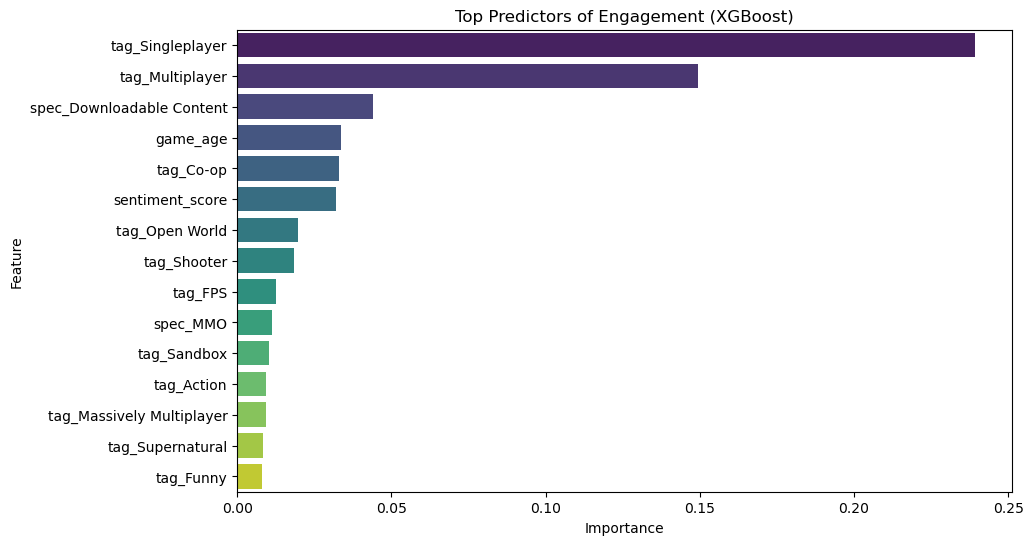

In [55]:
# Show top 15 features
imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_})
top_imp = imp.sort_values(by='Importance', ascending=False).head(15)
print(top_imp)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_imp, palette='viridis')
plt.title('Top Predictors of Engagement (XGBoost)')
plt.show()

# Recommendation Engine

In [61]:
def recommend_games(user_id, model, item_matrix, top_k=10):
    """
    1. Identify games the user already owns (to exclude them).
    2. Select a pool of Candidate Games (e.g., 100 random unowned games).
    3. Construct the Feature Vector for these candidates.
    4. Ask the Model to predict the probability of playing.
    5. Return the Top K games with the highest probability.
    """
    
    # 1. Get User History
    try:
        user_history = set(user_matrix[user_matrix['steam_id'] == user_id]['item_id'])
    except:
        user_history = set()
    
    # 2. Candidate Generation
    # pick 100 random games the user DOESN'T own.
    item_matrix['item_id'] = item_matrix['item_id'].astype(int)
    all_items = set(item_matrix['item_id'])
    candidates = list(all_items - user_history)
    
    # Safety check: if user owns almost everything
    if len(candidates) > 100:
        candidates = random.sample(candidates, 100)
    
    # 3. Build Prediction DataFrame
    # grab metadata for these candidates from item_matrix
    candidate_df = item_matrix[item_matrix['item_id'].isin(candidates)].copy()
    
    # IMPORTANT: ensure columns match X_train exactly!
    # (Drop non-feature columns like ID or raw strings)
    # We use the same 'drop_cols' logic from training
    X_pred = candidate_df.drop(columns=['item_id'], errors='ignore')
    X_pred = X_pred.select_dtypes(include=[np.number])
    
    # 4. Score Candidates
    # We use predict_proba to get the specific % chance (e.g., 0.85)
    # [:, 1] gets the probability of Class 1 (Played)
    probs = model.predict_proba(X_pred)[:, 1]
    
    # 5. Rank
    candidate_df['probability'] = probs
    recommendations = candidate_df.sort_values(by='probability', ascending=False).head(top_k)
    
    # return recommendations[['item_id', 'probability', 'popularity_log', 'price']]
    return recommendations[['item_id', 'probability', 'price']]

## Demo

In [64]:
# RECOMMEND FOR A RANDOM USER

# Pick a random user from the test set
random_user = df_training_data['steam_id'].sample(1).values[0]

print(f"Generating Recommendations for User: {random_user}")
recs = recommend_games(random_user, xgb, item_matrix_clean)

# Merge with item names
steam_games['id'] = steam_games['id'].astype(int)
recs_readable = recs.merge(steam_games[['id', 'app_name']], left_on='item_id', right_on='id', how='left')

print("\nTop 10 Recommended Games:")
print(recs_readable[['app_name', 'probability', 'price']])

Generating Recommendations for User: 76561198098156489

Top 10 Recommended Games:
                            app_name  probability  price
0                     Worms Reloaded     0.970208  19.99
1                       sZone-Online     0.868536   0.00
2         Super House of Dead Ninjas     0.814818   6.99
3                         Mini Metro     0.736130   9.99
4       Return to Castle Wolfenstein     0.632989   4.99
5             Dead State: Reanimated     0.628420  19.99
6             Heaven Island - VR MMO     0.536082   0.99
7                          Showtime!     0.504560   5.99
8                      Over The Void     0.267369   4.99
9  Luna: Shattered Hearts: Episode 1     0.265201   2.99


In [65]:
from IPython.display import HTML, display

def show_recommendations_with_images(recs_df):
    """
    Takes the recommendation dataframe and renders an HTML table 
    with game box art using Steam's public CDN.
    """
    html = "<h3>🚀 Top 10 Personalized Recommendations</h3>"
    html += "<table style='width:100%; text-align:left;'>"
    html += "<tr><th>Image</th><th>Game Title</th><th>Confidence</th><th>Price</th></tr>"
    
    for _, row in recs_df.iterrows():
        app_id = row['item_id']
        name = row['app_name']
        prob = row['probability']
        price = row['price']
        
        # Steam Header Image URL Pattern
        img_url = f"https://cdn.akamai.steamstatic.com/steam/apps/{app_id}/header.jpg"
        
        # formatting
        prob_color = "green" if prob > 0.8 else "orange" if prob > 0.5 else "red"
        
        html += f"""
        <tr>
            <td style='width:150px'><img src='{img_url}' style='width:120px; border-radius:5px;'></td>
            <td style='font-weight:bold; font-size:14px'>{name}</td>
            <td style='color:{prob_color}; font-weight:bold'>{prob:.1%}</td>
            <td>${price}</td>
        </tr>
        """
    html += "</table>"
    display(HTML(html))

# Run it on your results
# Make sure your recs_readable has 'item_id' (it might have been lost in merge or named 'id')
recs_readable['item_id'] = recs_readable['id'] # Ensure ID is there
show_recommendations_with_images(recs_readable)

Image,Game Title,Confidence,Price
,Worms Reloaded,97.0%,$19.99
,sZone-Online,86.9%,$0.0
,Super House of Dead Ninjas,81.5%,$6.99
,Mini Metro,73.6%,$9.99
,Return to Castle Wolfenstein,63.3%,$4.99
,Dead State: Reanimated,62.8%,$19.99
,Heaven Island - VR MMO,53.6%,$0.99
,Showtime!,50.5%,$5.99
,Over The Void,26.7%,$4.99
,Luna: Shattered Hearts: Episode 1,26.5%,$2.99
